In [1]:
import pandas as pd
import warnings
import time
# import all data and preprocess
users = pd.read_csv('BX-Users.csv',sep='";', engine = 'python')
books = pd.read_csv('BX-Books.csv',sep='";"',engine='python')
ratings = pd.read_csv('BX-Book-Ratings.csv',sep='";"', engine = 'python')


In [2]:
# functions to clean data
def user_id(s):
    return s.strip('"')
def check_zero_rating(number):
    if number != 0:
        return number
def ratings_user(s):
    A = s.split(";")
    userid = A[0].strip('"')
    return userid
def ratings_isbn(s):
    A = s.split(";")
    isbn = A[1].strip('"')
    return isbn
def ratings_rate(s):
    return int(s.strip(",").strip('"'))
def age_clean(s):
    try:
        return s.strip('""')
    except:
        return 0
def loc_clean(s):
    return str(s).split(",")[-1]

# replace data with cleaned version
users["age"] = users['"Age"'].map(age_clean)
users["loc"] = users['"Location'].map(loc_clean)
users['UserID'] = users['"User-ID'].map(user_id)

books['ISBN'] = books['"ISBN'].map(user_id)
ratings['ISBN'] = ratings['"User-ID;""ISBN"'].map(ratings_isbn)
ratings["UserID"] = ratings['"User-ID;""ISBN"'].map(ratings_user)
ratings["BookRating"] = ratings['"Book-Rating""",,'].map(ratings_rate)
ratings["BookRating"] = ratings["BookRating"].map(check_zero_rating)
ratings = ratings.drop(labels = ['"User-ID;""ISBN"','"Book-Rating""",,'],axis = 1).dropna()

In [4]:
Meanratings = dict(pd.Series(ratings.groupby(["UserID"])["BookRating"].mean())) # User-mean
Meanbook = dict(pd.Series(ratings.groupby(["ISBN"])["BookRating"].mean())) # Book - mean
CountuserRating = dict(pd.Series(ratings.groupby(["UserID"])["BookRating"].count())) # User - num ratings
CountbookRating = dict(pd.Series(ratings.groupby(["ISBN"])["BookRating"].count())) # Book - num ratings
tempBooks = books.set_index("ISBN", drop=False)
IsbnToTitle = dict(tempBooks["Book-Title"])
IsbnImg = dict(tempBooks["Image-URL-M"])
IsbnAuthor = dict(tempBooks["Book-Author"])

# define agg. statistics to use for collab filtering
def set_mean(userid):
    try:
        return Meanratings[userid]
    except:
        return 0
def set_book(isbn):
    try:
        return Meanbook[isbn]
    except:
        return 0
def count_user(userid):
    try:
        return CountuserRating[userid]
    except:
        return 0
def count_books(isbn):
    try:
        return CountbookRating[isbn]
    except:
        return 0
def set_location(s):
        return ual[s][1].strip(" ")
def set_age(s):
        return int(ual[s][0])
    
ratings["MeanRatingUser"] = ratings["UserID"].map(set_mean)
ratings["MeanRatingBook"] = ratings["ISBN"].map(set_book)
ratings["UserRatings"] = ratings["UserID"].map(count_user)
ratings["BookRatings"] = ratings["ISBN"].map(count_books)

ual = {} # key - user, values- tuple of age, location
i = 0 #can set index to make faster
while i < len(users):
    ual[users.iloc[i][5]] = (users.iloc[i][3],users.iloc[i][4])
    i+=1

ratings["Location"] = ratings["UserID"].map(set_location)
ratings["Age"] = ratings["UserID"].map(set_age)

In [7]:
# Enter a new user's book ratings from file provided, return a line of dataframe with all info
def new_user(filename, UserName, Age, loc):
    new = pd.read_csv(filename,sep=',', engine = 'python', names = ["IsbnBook","BookRating"])
    new = new.dropna()
    def just_isbn(s):
        return s.split()[0]
    new["ISBN"] = new["IsbnBook"].map(just_isbn)
    new["Age"] = Age
    new["Location"] = loc
    new["UserID"] = UserName
    new["MeanRatingUser"] = sum(new["BookRating"])/len(new)
    new["UserRatings"] = len(new)
    new["BookRatings"] = new["ISBN"].map(count_books)
    new["MeanRatingBook"] = new["ISBN"].map(set_book)
    
    return new[["ISBN","UserID","BookRating","BookRatings","Location","Age","UserRatings","MeanRatingUser","MeanRatingBook"]]



In [9]:
def preprocess(lb, up, location):
    """Trim down original dataframe based on age bounds and location to get more specific recommendations"""
    lower = ratings[ratings["Age"] >= min(lb,up)]
    upper = lower[lower["Age"] <= max(lb,up)]
    if location == "usa":
        return upper[upper["Location"] == "usa"]
    elif location == "None":
        return upper
    else:
        return upper[upper["Location"] != "usa"]
    
cleaned = preprocess(0,155,"None") # Final dataframe to be used in calculations
cleaned[:5]

,Age,BookRating,BookRatings,ISBN,Location,MeanRatingBook,MeanRatingUser,UserID,UserRatings
14,54,8.0,138,0440220602,usa,7.391304,5.545455,PaulBohl,11
22,54,5.0,84,0446611212,usa,7.738095,5.545455,PaulBohl,11
104,54,3.0,34,0316603570,usa,8.147059,5.545455,PaulBohl,11
105,54,2.0,57,0316693200,usa,7.912281,5.545455,PaulBohl,11
290,54,1.0,162,0446610038,usa,7.722222,5.545455,PaulBohl,11


In [10]:
Master = cleaned[["ISBN","UserID","BookRating","UserRatings","BookRatings"]]
def drop_UserRatings(number):
    if number > 4: # min number of user ratings needed
        return number
def drop_BookRatings(number):
    if number > 15: # min number of book ratings needed
        return number
Master["UserRatings"] = Master["UserRatings"].map(drop_UserRatings)
Master["BookRatings"] = Master["BookRatings"].map(drop_BookRatings)
Master = Master.dropna() 
Master[:5]

,ISBN,UserID,BookRating,UserRatings,BookRatings
14,0440220602,PaulBohl,8.0,11.0,138.0
22,0446611212,PaulBohl,5.0,11.0,84.0
104,0316603570,PaulBohl,3.0,11.0,34.0
105,0316693200,PaulBohl,2.0,11.0,57.0
290,0446610038,PaulBohl,1.0,11.0,162.0


In [11]:
A = pd.DataFrame(pd.pivot_table(Master, values = "BookRating", index = Master["ISBN"], columns = Master["UserID"]))
B = A.corr(min_periods=3) # requires 3 ratings of similar books in order to calculate correlation

In [12]:
def Prediction(userid):
    """ UBCF
    Take an input of userID, all books
        - calculate correlation of other users
        - take top/bottom N of correlated users
        - calculate weights for rating
        - weight*(rating of book - mean of all ratings)
        - sum weights for final rating
        - return rating
    """
    D = dict(B[userid].dropna())
    try:
        D.pop(userid)
    except:
        pass
    corrSum = 0.0
    for k in D.keys():
        corrSum += abs(D[k])
    weights = {}
    for k in D.keys():
        weights[k] = D[k]/corrSum
    predBookValues = {}
    
    for u in D.keys():
        bookrating = dict(A[u].dropna())
        for b in Master["ISBN"].drop_duplicates().values:
            try:
                predBookValues[b] += weights[u]*(Meanratings[u]- bookrating[b])
            except: 
                try:
                    predBookValues[b] = weights[u]*(Meanratings[u] - bookrating[b])
                except:
                    continue
    return predBookValues 


We recommend the following books to read next: 

1) The Pelican Brief by John Grisham
2) The Eight by Katherine Neville
3) The Bridge Across Forever by Richard Bach
4) The Firm by John Grisham
5) The Idiot Girls' Action Adventure Club by Laurie Notaro


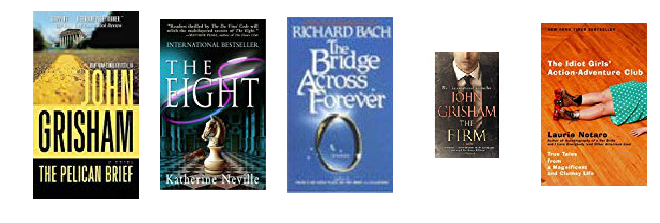

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

def show_image(isbnNum,counter):
    from PIL import Image
    import urllib.request, io
    from IPython.display import Image as I
    from IPython.display import display
    
    path = 'temp'+ str(counter)+'.png'
    url = IsbnImg[isbnNum]
    with urllib.request.urlopen(url) as url:
        with open(path,'wb') as f:
            f.write(url.read())
            
    print(str(counter + 1) + ") "+IsbnToTitle[isbnNum] + " by " + IsbnAuthor[isbnNum])
def show_photos():
    # figure size in inches optional
    rcParams['figure.figsize'] = 11 ,8

    # read images
    img_A = plt.imread('temp0.png',0)
    img_B = plt.imread('temp1.png',0)
    img_C = plt.imread('temp2.png',0)
    img_D = plt.imread('temp3.png',0)
    img_E = plt.imread('temp4.png',0)

    # display images
    fig, ax = plt.subplots(1,5)

    ax[0].imshow(img_A)
    ax[1].imshow(img_B)
    ax[2].imshow(img_C)
    ax[3].imshow(img_D)
    ax[4].imshow(img_E)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')

# As is, will find predictions for every user for each book, if commented out, uncomment second line in get_top5.
# This will provide predictions for a single user at a time. 
AllPredictions = {}
for user in Classmates: # All users
    AllPredictions[user] = Prediction(user) # Key = user id, value = dictionary of k=book,v=pRating

def get_top5_recommends(uID):
    predDict = AllPredictions[uID]
    #predDict = Prediction(uID)
    BooksRated = dict(A[uID].dropna())
    for b in BooksRated:
        try:
            predDict.pop(b) # Only get predicted values
        except:
            pass 
    Top5 = sorted(predDict, key=predDict.get, reverse=True)[:5]
    print("We recommend the following books to read next: \n")
    for k,item in enumerate(Top5):
        show_image(item,k)

get_top5_recommends("PaulBohl")
show_photos()